## Importing necessary libraries

In [ ]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose, Conv2D, Dropout, Flatten
from keras.optimizers import Adam
import matplotlib.pyplot as plt

## Setting the data up

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()  #loading the data into X_train(images) and y_train(labels)


X_train = X_train.reshape(X_train.shape[0], 28,28, 1)
# The original pixel values range from 0 to 255, so subtracting 127.5 and then dividing by 127.5 transforms the range to [-1, 1]
X_train = (X_train - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Define the buffer size for shuffling the dataset
# BUFFER_SIZE should be greater than or equal to the size of the dataset to ensure thorough shuffling
BUFFER_SIZE = 60000
# Define the batch size
BATCH_SIZE = 256

# Create a TensorFlow Dataset object from the training data
# This allows for efficient data manipulation, such as batching and shuffling

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Batch the dataset using the defined batch size
# Batching the data allows for processing multiple samples simultaneously, improving training efficiency


## Generator

In [ ]:
def create_generator():
    generator = Sequential([
        Dense(256, input_shape = (100,)),  # First dense layer with 256 neurons and takes in one sample of 100 values
        BatchNormalization(),
        LeakyReLU(alpha = 0.2),   # Leaky ReLU with alpha(slope) as 0.2

        Dense(512),
        LeakyReLU(alpha = 0.2),

        Dense(1024),
        LeakyReLU(alpha = 0.2),

        Dense(784, activation = 'tanh'),  #output layer has 784(28x28) neurons which can represent a digit image
        Reshape((28, 28, 1))
    ])

    return generator

g = create_generator()
gen_opt = Adam(learning_rate = 0.01)
g.compile(loss='binary_crossentropy', optimizer = gen_opt)
g.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 256)               25856     
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 1024)              525312    
                                                      

## Testing with random noise

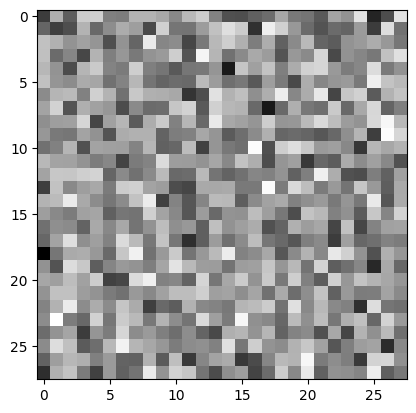

In [ ]:
# Create a random noise and generate a sample
noise = tf.random.normal([1, 100])
generated_image = g(noise, training=False)
# Visualize the generated sample
generated_image = generated_image.numpy().reshape(28, 28)
plt.imshow(generated_image, cmap='gray')

## Discriminator

In [ ]:
def create_discriminator():
    discriminator = Sequential([
        Flatten(input_shape=(28, 28, 1)),
        Dense(1024, input_shape = (784,)),  # First dense layer with 128 neurons and takes in one sample of 100 values
        LeakyReLU(alpha = 0.2),   # Leaky ReLU with alpha(slope) as 0.2
        Dropout(0.3),

        Dense(512),
        LeakyReLU(alpha = 0.2),
        Dropout(0.3),
        Dense(256),
        LeakyReLU(alpha = 0.2),

        Dense(1, activation = 'sigmoid')  #output layer has 784(28x28) neurons which can represent a digit image
    ])
    return discriminator

d = create_discriminator()
disc_opt = Adam(learning_rate = 0.01)
d.compile(loss='binary_crossentropy', optimizer = disc_opt)
d.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 1024)              803840    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 512)               0         
                                                                 
 dropout_5 (Dropout)         (None, 512)              

## Gen loss and Disc loss

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

@tf.function

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)

## Checkpoint

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_opt,
                                 discriminator_optimizer=disc_opt,
                                 generator=g,
                                 discriminator=d)
# Restore the latest checkpoint if it exists
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f"Restored from {latest_checkpoint}")
else:
    print("Starting training from scratch.")

Starting training from scratch.


## Some parameters

In [ ]:
EPOCHS = 60
num_examples_to_generate = 16
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
@tf.function #decorator
def train_step(images):

    # 1 - Create a random noise to feed it into the model
    # for the image generation
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # 2 - Generate images and calculate loss values
    # GradientTape method records operations for automatic differentiation.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = g(noise, training=True)

      real_output = d(images, training=True)
      fake_output = d(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss,
                                               g.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                d.trainable_variables)
      gen_opt.apply_gradients(zip(gradients_of_generator, g.trainable_variables))
      disc_opt.apply_gradients(zip(gradients_of_discriminator, d.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    # 1 - Generate images
    predictions = model(test_input, training=False)

    # Handle 2D tensors
    if len(predictions.shape) == 2:
        predictions = predictions[:, tf.newaxis, :, :]

    # 2 - Plot the generated images
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # 3 - Save the generated images
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch,
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(g,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(g,
                           epochs,
                           seed)

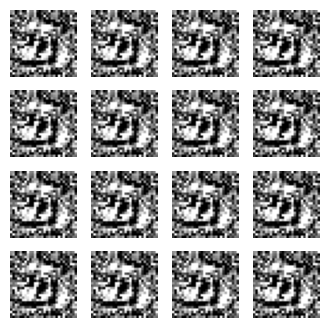

In [ ]:
train(train_dataset,EPOCHS)